In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go



In [ ]:

#  Cargar los datos
df = pd.read_csv('../data/training_pruebas.csv', encoding='latin1', sep=';', on_bad_lines='skip')
print(df.shape)


# umbral para eliminar columnas con demasiados valores nulos
threshold = 0.5  # 50% de nulos

initial_size = df.shape

columns_to_remove = df.columns[df.isnull().mean() > threshold]


for column in columns_to_remove:
    df.drop(column, axis=1, inplace=True)


# Llenar los valores nulos en columnas numéricas con la media de cada columna
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    mean_value = df[col].mean()
    df[col].fillna(mean_value, inplace=True) 
    print(f"Llenada columna '{col}' con la media: {mean_value}")


In [5]:

# Limpiar la columna 'FAMI_ESTRATOVIVIENDA'
df['FAMI_ESTRATOVIVIENDA'] = df['FAMI_ESTRATOVIVIENDA'].str.replace('Estrato ', '').str.strip()

df['FAMI_ESTRATOVIVIENDA'] = pd.to_numeric(df['FAMI_ESTRATOVIVIENDA'], errors='coerce')

# Calcular la media de los valores disponibles en la columna y redondear al entero más cercano
mean_value = round(df['FAMI_ESTRATOVIVIENDA'].mean())

# Reemplazar NaN con la media calculada (ya redondeada)
df['FAMI_ESTRATOVIVIENDA'].fillna(mean_value, inplace=True)

# Convertir la columna a tipo entero
df['FAMI_ESTRATOVIVIENDA'] = df['FAMI_ESTRATOVIVIENDA'].astype(int)

In [ ]:
df['FAMI_EDUCACION_PADRES_COMBINADA'] = df['FAMI_EDUCACIONPADRE'] + df['FAMI_EDUCACIONMADRE']

# Crear una variable binaria para acceso a tecnología
df['ACCESO_TECNOLOGIA'] = ((df['FAMI_TIENECOMPUTADOR'] == 'Si') & (df['FAMI_TIENEINTERNET'] == 'Si')).astype(int)

#Crear una variable categórica para el nivel de trabajo del estudiante
def categorizar_horas_trabajo(horas):
    if horas == '0':
        return 'No trabaja'
    elif horas == 'Menos de 10 horas':
        return 'Tiempo parcial bajo'
    elif horas in ['Entre 11 y 20 horas', 'Entre 21 y 30 horas']:
        return 'Tiempo parcial alto'
    else:
        return 'Tiempo completo'

df['NIVEL_TRABAJO_ESTUDIANTE'] = df['ESTU_HORASSEMANATRABAJA'].apply(categorizar_horas_trabajo)

# Crear una variable que indique si el estudiante se preparó para el examen
df['PREPARO_EXAMEN'] = (df['ESTU_COMOCAPACITOEXAMENSB11'] != 'No realizó ninguna prueba de preparación').astype(int)

# 5. Crear una variable que combine el estrato socioeconómico con el pago de matrícula
def combinar_estrato_matricula(estrato, matricula):
    if pd.isna(estrato) or pd.isna(matricula):
        return np.nan
    return f"{estrato}_{matricula}"

df['ESTRATO_MATRICULA'] = df.apply(lambda row: combinar_estrato_matricula(row['FAMI_ESTRATOVIVIENDA'], row['ESTU_VALORMATRICULAUNIVERSIDAD']), axis=1)

# Crear una variable que indique si el estudiante es de primera generación en la universidad
df['PRIMERA_GENERACION_UNIV'] = ((df['FAMI_EDUCACIONPADRE'] != 'Educación profesional completa') & 
                                 (df['FAMI_EDUCACIONMADRE'] != 'Educación profesional completa')).astype(int)

#Crear una variable que combine el método del programa y el carácter de la institución
df['METODO_CARACTER_COMBINADO'] = df['ESTU_METODO_PRGM'] + '_' + df['INST_CARACTER_ACADEMICO']

# Crear una variable que indique si el estudiante reside en el mismo municipio donde estudia
df['RESIDE_DONDE_ESTUDIA'] = (df['ESTU_MCPIO_RESIDE'] == df['ESTU_PRGM_MUNICIPIO']).astype(int)

print(df[['FAMI_EDUCACION_PADRES_COMBINADA', 'ACCESO_TECNOLOGIA', 'NIVEL_TRABAJO_ESTUDIANTE', 
          'PREPARO_EXAMEN', 'ESTRATO_MATRICULA', 'PRIMERA_GENERACION_UNIV', 
          'METODO_CARACTER_COMBINADO', 'RESIDE_DONDE_ESTUDIA']].dtypes)


In [ ]:
categorical_columns = ['FAMI_EDUCACION_PADRES_COMBINADA', 'NIVEL_TRABAJO_ESTUDIANTE', 
                       'ESTRATO_MATRICULA', 'METODO_CARACTER_COMBINADO']

df_dummies = pd.get_dummies(df[categorical_columns], drop_first=True)

correlations = df.corr()['PUNT_GLOBAL'].sort_values(key=abs, ascending=False)

# filtrar las columnas dummy que tienen correlaciones mayores que 0.15
high_correlation_vars = correlations[correlations.abs() > 0.15].index.tolist()

# Unir solo las variables que cumplen la condición
df_high_corr = pd.concat([df[high_correlation_vars], df_dummies], axis=1)

new_correlations = df_high_corr.corr()['PUNT_GLOBAL'].sort_values(key=abs, ascending=False)

print("\nCorrelaciones con PUNT_GLOBAL (de mayor a menor):")
print(new_correlations)


In [ ]:
from datetime import datetime

df['ESTU_FECHANACIMIENTO'] = pd.to_datetime(df['ESTU_FECHANACIMIENTO'], format='%d/%m/%Y', errors='coerce')
fecha_actual = pd.to_datetime(datetime.today())


df['EDAD'] = (fecha_actual - df['ESTU_FECHANACIMIENTO']).dt.days // 365
df.drop(columns='ESTU_FECHANACIMIENTO', inplace=True)


mean_value = df['EDAD'].mean()
df['EDAD'].fillna(mean_value, inplace=True)  

print(df['EDAD'].head())



In [ ]:
df['TECNOLOGIA_METODO'] = df['ACCESO_TECNOLOGIA'] * pd.get_dummies(df['ESTU_METODO_PRGM'])['PRESENCIAL']

df['TRABAJO_PREPARACION'] = df['NIVEL_TRABAJO_ESTUDIANTE'].astype(str) + '_' + df['PREPARO_EXAMEN'].astype(str)
df = pd.get_dummies(df, columns=['TRABAJO_PREPARACION'], drop_first=True)


numerical_columns = df.select_dtypes(include=['number']).columns
correlations = df[numerical_columns].corr()['PUNT_GLOBAL'].sort_values(key=abs, ascending=False)

print("\nCorrelaciones de las nuevas variables combinadas con PUNT_GLOBAL (de mayor a menor):")
print(correlations)


In [ ]:
categorical_cols = df.select_dtypes(include=np.object_).columns

for column in categorical_cols:
    unique_count = df[column].nunique()
    print(f"Cantidad de valores únicos en la columna '{column}': {unique_count}")
print(df.shape)

In [ ]:
columns_to_remove = []

# Verificar las columnas categóricas y agregar a la lista si tienen un solo valor único
for column in categorical_cols:
    if df[column].nunique() <= 1 or df[column].nunique() >= 1000:   columns_to_remove.append(column)

# Eliminar columnas que tienen solo un valor único
if columns_to_remove:
    df.drop(columns=columns_to_remove, inplace=True)

    # Mostrar las columnas eliminadas y el tamaño del DataFrame después de la eliminación
    for column in columns_to_remove:
        print(f"Eliminada columna: {column}")

print(f"Tamaño del dataset después de eliminar columnas: {df.shape}")


In [ ]:
categorical_cols = df.select_dtypes(include=np.object_).columns

for column in categorical_cols:
    dummies = pd.get_dummies(df[column], prefix='DUMMY', drop_first=True)
    
    correlation_with_target = dummies.corrwith(df['PUNT_GLOBAL'])
    
    # Filtrar dummies con correlación mayor a 0.15
    significant_dummies = correlation_with_target[correlation_with_target.abs() > 0.18]

    # Si hay dummies significativas, añadirlas al DataFrame original
    if not significant_dummies.empty:
        for dummy in significant_dummies.index:
            df[dummy] = dummies[dummy]

print("DataFrame final con las columnas dummy de alta correlación:")


In [182]:
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()

corr_with_punt_global = df[numerical_columns].corr()['PUNT_GLOBAL'].drop('PUNT_GLOBAL')

corr_df = pd.DataFrame(corr_with_punt_global).reset_index()
corr_df.columns = ['Variable', 'Correlación con PUNT_GLOBAL']

# Filtrar las correlaciones mayores a 0.18
filtered_corr_df = corr_df[abs(corr_df['Correlación con PUNT_GLOBAL']) >= 0.18]

# Crear el Heatmap
fig = go.Figure(data=go.Heatmap(
                z=filtered_corr_df['Correlación con PUNT_GLOBAL'].values.reshape(1, -1),
                x=filtered_corr_df['Variable'],
                y=['PUNT_GLOBAL'],
                colorscale='RdBu',
                zmin=-1, zmax=1,
                text=filtered_corr_df['Correlación con PUNT_GLOBAL'].values.reshape(1, -1),
                texttemplate='%{text:.2f}',
                textfont={"size":10},
                hoverongaps=False))

fig.update_layout(title='Correlación de Variables con PUNT_GLOBAL (mayor a 0.18)', width=1000, height=400)
fig.show()


In [ ]:
correlation_matrix = df[filtered_corr_df['Variable']].corr()

numerical_columns = df.select_dtypes(include=[np.number]).columns


# Filtrar la matriz de correlación
correlation_matrix_filtered = correlation_matrix.loc[filtered_corr_df['Variable']]

# Crear el Heatmap
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix_filtered.values,
    x=correlation_matrix_filtered.columns,
    y=correlation_matrix_filtered.columns,
    colorscale='RdBu',
    zmin=-1, zmax=1,
    text=correlation_matrix_filtered.values,
    texttemplate='%{text:.2f}',
    textfont={"size":10},
    hoverongaps=False))

fig.update_layout(title='Matriz de Correlación', width=1000, height=1000)
fig.show()

In [186]:
dk = df[filtered_corr_df['Variable']]

dk.columns.tolist()

['FAMI_ESTRATOVIVIENDA',
 'INST_COD_INSTITUCION',
 'ESTU_SNIES_PRGMACADEMICO',
 'ESTU_NSE_INDIVIDUAL',
 'ESTU_NSE_IES',
 'EDAD',
 'TECNOLOGIA_METODO',
 'DUMMY_Más de 7 millones',
 'DUMMY_TI',
 'DUMMY_Entre un millon y 3 millones de pesose',
 'DUMMY_Mas de 7 millones',
 'DUMMY_UNIVERSIDAD NACIONAL DE COLOMBIA-BOGOTÁ D.C.',
 'DUMMY_PRESENCIAL',
 'DUMMY_INSTITUCIÓN UNIVERSITARIA',
 'DUMMY_UNIVERSIDAD',
 'DUMMY_PRESENCIAL_UNIVERSIDAD']

In [184]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import pandas as pd

# Suponiendo que 'dk' es tu DataFrame
X = dk  # Otras características
y = df['PUNT_GLOBAL']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# No se escalan los datos

params = {
'n_estimators': 200,
    'max_depth': 11,
    'min_samples_split': 10,
    'min_samples_leaf': 2,
    'learning_rate': 0.03,
    'max_features': 'sqrt'
}

gbm = GradientBoostingRegressor(random_state=42, **params)

# Entrenar el modelo
gbm.fit(X_train, y_train)




GradientBoostingRegressor(learning_rate=0.03, max_depth=11, max_features='sqrt',
                          min_samples_leaf=2, min_samples_split=10,
                          n_estimators=200, random_state=42)

In [185]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Predecir en el conjunto de entrenamiento y prueba
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calcular MSE y R² para el conjunto de entrenamiento
    mse_train = mean_squared_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # Calcular MSE y R² para el conjunto de prueba
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Calcular MAPE para el conjunto de entrenamiento y prueba
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

    # Imprimir los resultados
    print(f"Train MSE: {mse_train:.4f}")
    print(f"Train R²: {r2_train:.4f}")
    print(f"Train MAPE: {mape_train * 100:.2f}%")
    print(f"Test MSE: {mse_test:.4f}")
    print(f"Test R²: {r2_test:.4f}")
    print(f"Test MAPE: {mape_test * 100:.2f}%")

# Llamar a la función con el modelo y los conjuntos de datos
evaluate_model(gbm, X_train, y_train, X_test, y_test)


Train MSE: 281.0551
Train R²: 0.4883
Train MAPE: 608670589913726.50%
Test MSE: 354.4139
Test R²: 0.3600
Test MAPE: 2749280772630044.00%


In [187]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

X = dk  
y = df['PUNT_GLOBAL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('ridge', Ridge(alpha=10))
])

# Entrenar el modelo
pipeline.fit(X_train, y_train)



Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('ridge', Ridge(alpha=10))])

In [188]:


# Hacer predicciones
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Calcular métricas de rendimiento
def print_metrics(y_true, y_pred, set_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'Métricas para el conjunto {set_name}:')
    print(f'MSE: {mse:.4f}')
    print(f'R2: {r2:.4f}\n')

print_metrics(y_train, y_train_pred, 'de entrenamiento')
print_metrics(y_test, y_test_pred, 'de prueba')

Métricas para el conjunto de entrenamiento:
MSE: 381.5183
R2: 0.3055

Métricas para el conjunto de prueba:
MSE: 387.7251
R2: 0.2999



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.neighbors import KNeighborsRegressor

X = dk  # Otras características
y = df['PUNT_GLOBAL']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Crear el modelo KNN (n_neighbors determina cuántos vecinos usar)
knn = KNeighborsRegressor(n_neighbors=20)

# Entrenar el modelo
knn.fit(X_train, y_train)



In [ ]:
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Calcular métricas de rendimiento
def print_metrics(y_true, y_pred, set_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f'Métricas para el conjunto {set_name}:')
    print(f'MSE: {mse:.4f}')
    print(f'R2: {r2:.4f}')
    print(f'MAPE: {mape:.4f}\n')

print_metrics(y_train, y_train_pred, 'de entrenamiento')
print_metrics(y_test, y_test_pred, 'de prueba')

C:\Users\CRISTIAN\AppData\Local\Temp\ipykernel_16816\3254240304.py:5: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



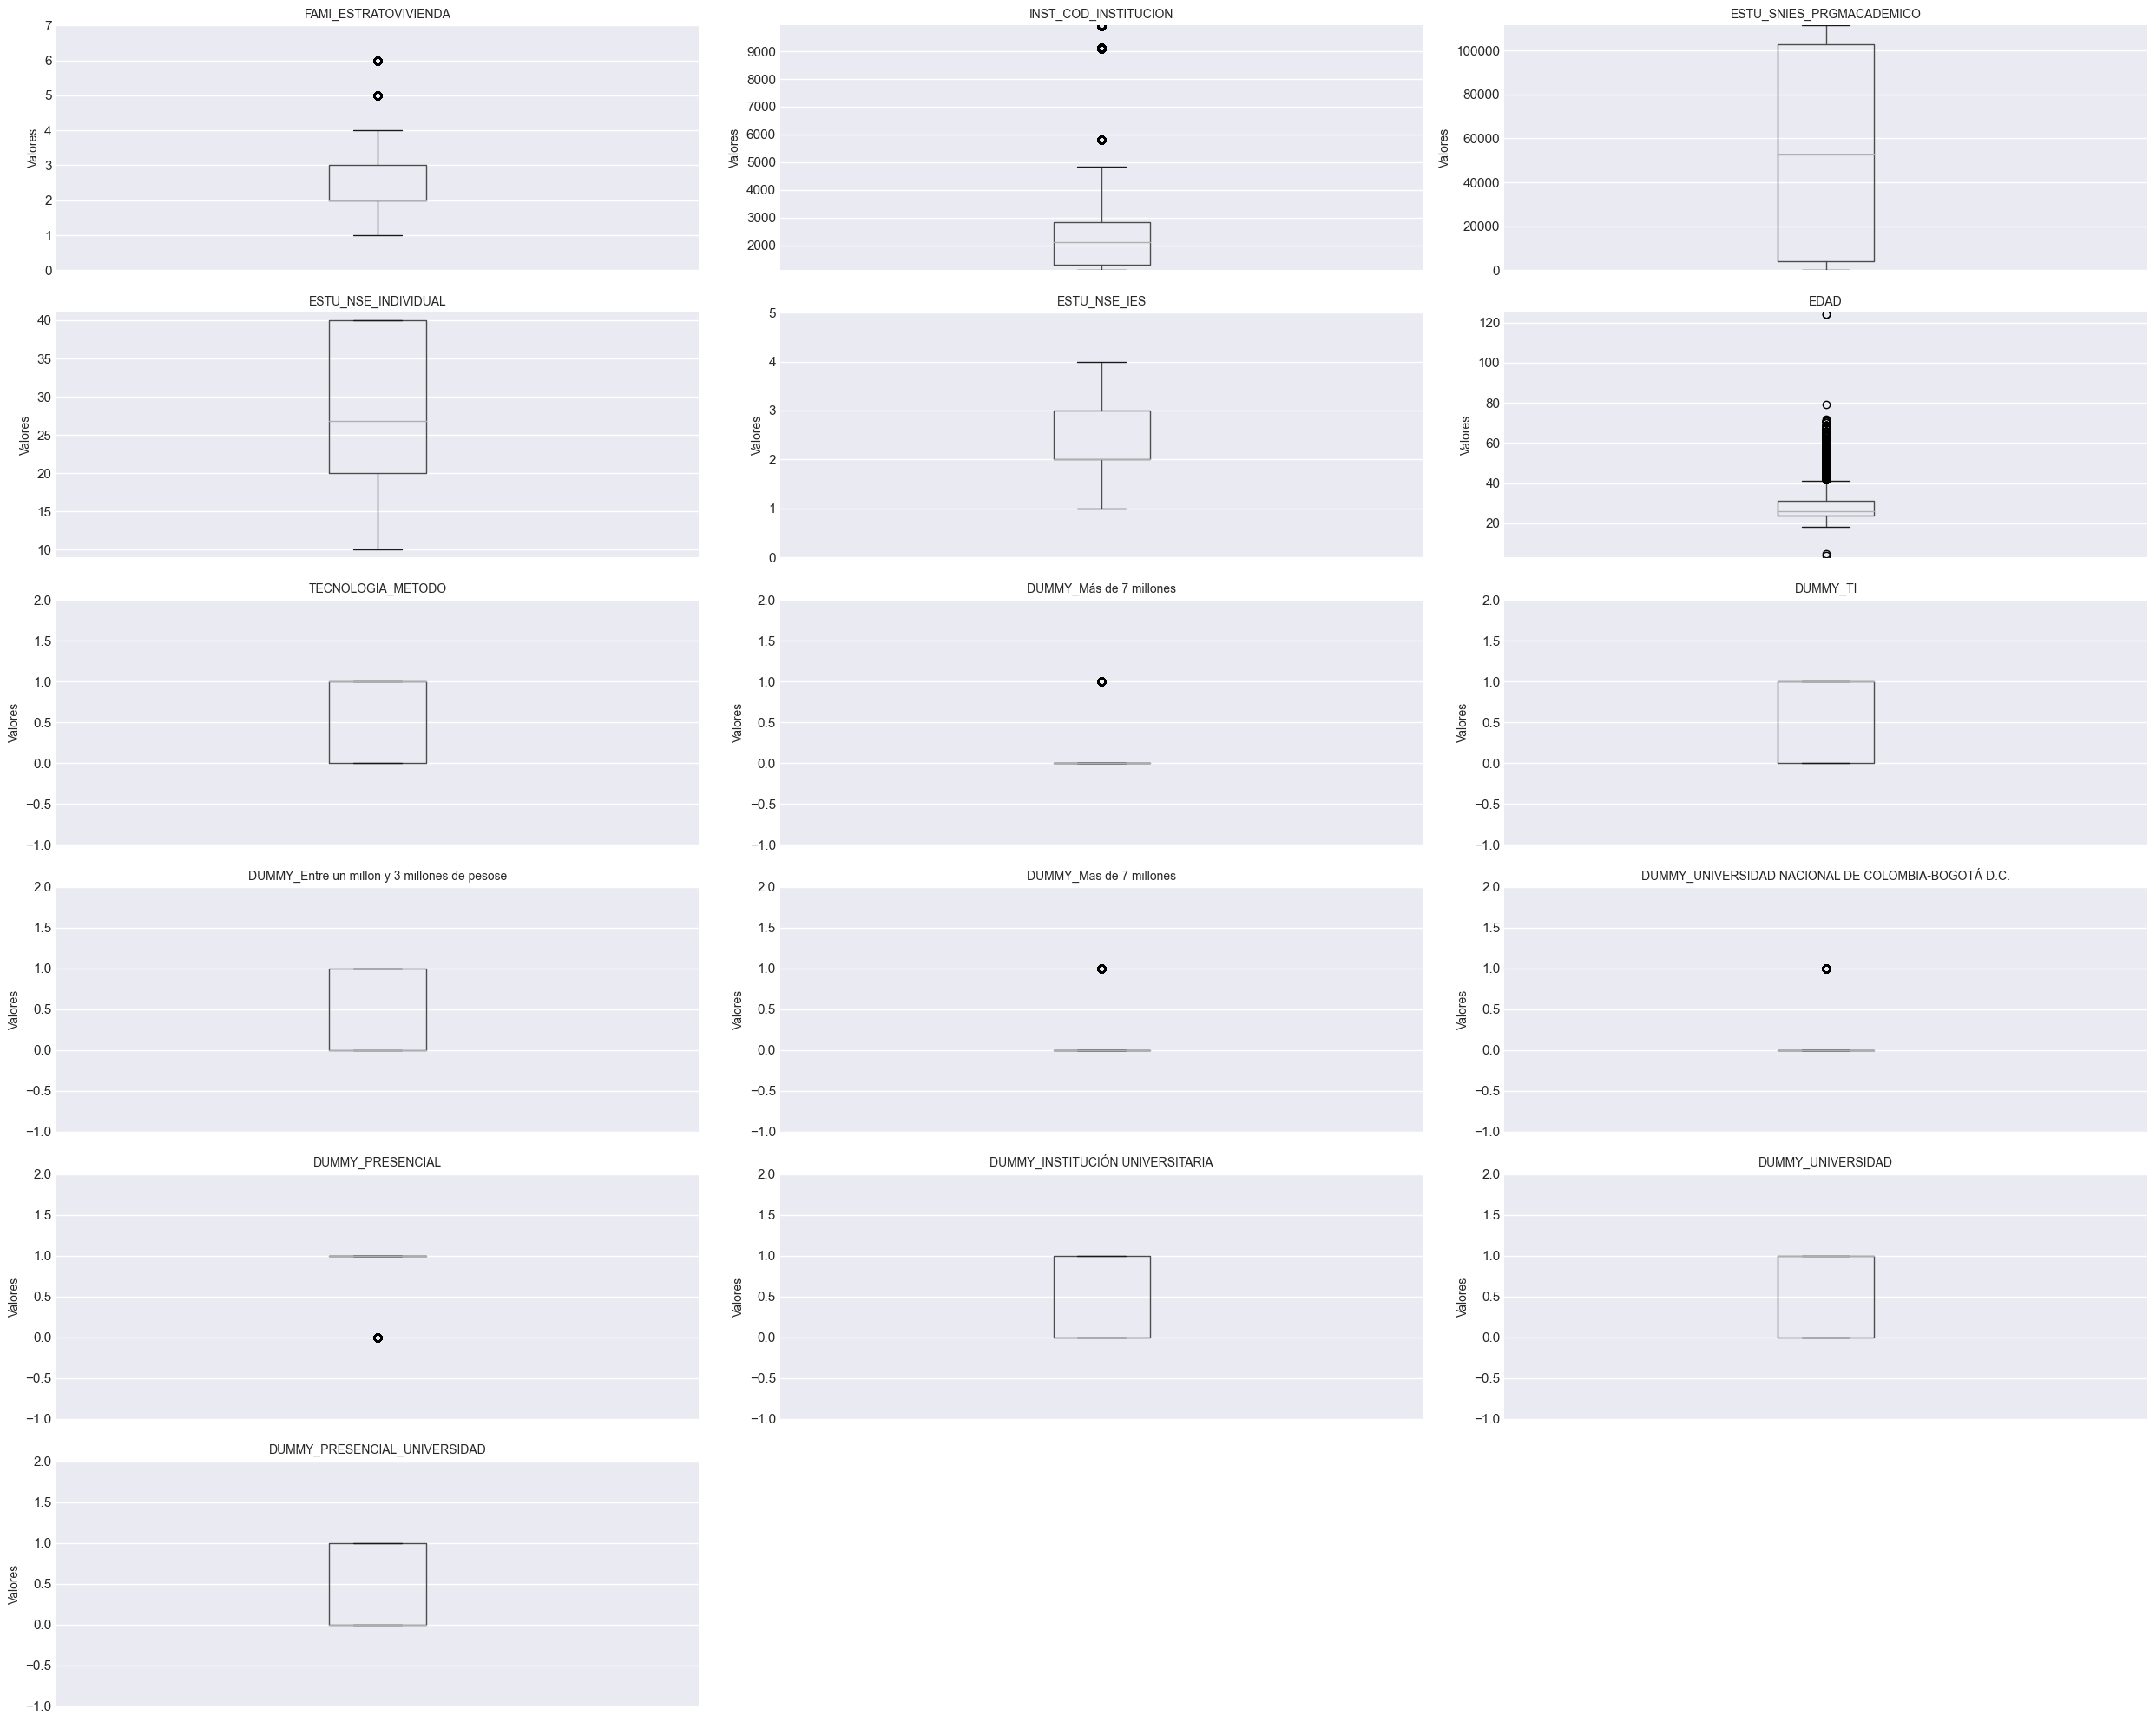

In [179]:
import matplotlib.pyplot as plt
import numpy as np

# Establecer un estilo para mejorar la apariencia
plt.style.use('seaborn-darkgrid')

# Filtramos las variables numéricas
numerical_columns = filtered_corr_df['Variable'].tolist()

# Configuramos el número de columnas y filas de subgráficas
cols = 3  # Número de columnas de subgráficas
rows = (len(numerical_columns) // cols) + (len(numerical_columns) % cols > 0)  # Calculamos filas necesarias

plt.figure(figsize=(25, 20))

# Creamos las subgráficas
for i, var in enumerate(numerical_columns):
    plt.subplot(rows, cols, i + 1)  # Seleccionamos la subgráfica
    df[[var]].boxplot()
    plt.title(var, fontsize=10)  
    plt.ylabel('Valores', fontsize=10)  
    plt.xticks([])  # Oculta las etiquetas del eje x
    plt.grid(True)  
    plt.ylim(df[var].min() - 1, df[var].max() + 1)  # Ajusta los límites del eje y

plt.tight_layout()  # Ajusta la disposición
plt.show()  # Muestra la figura


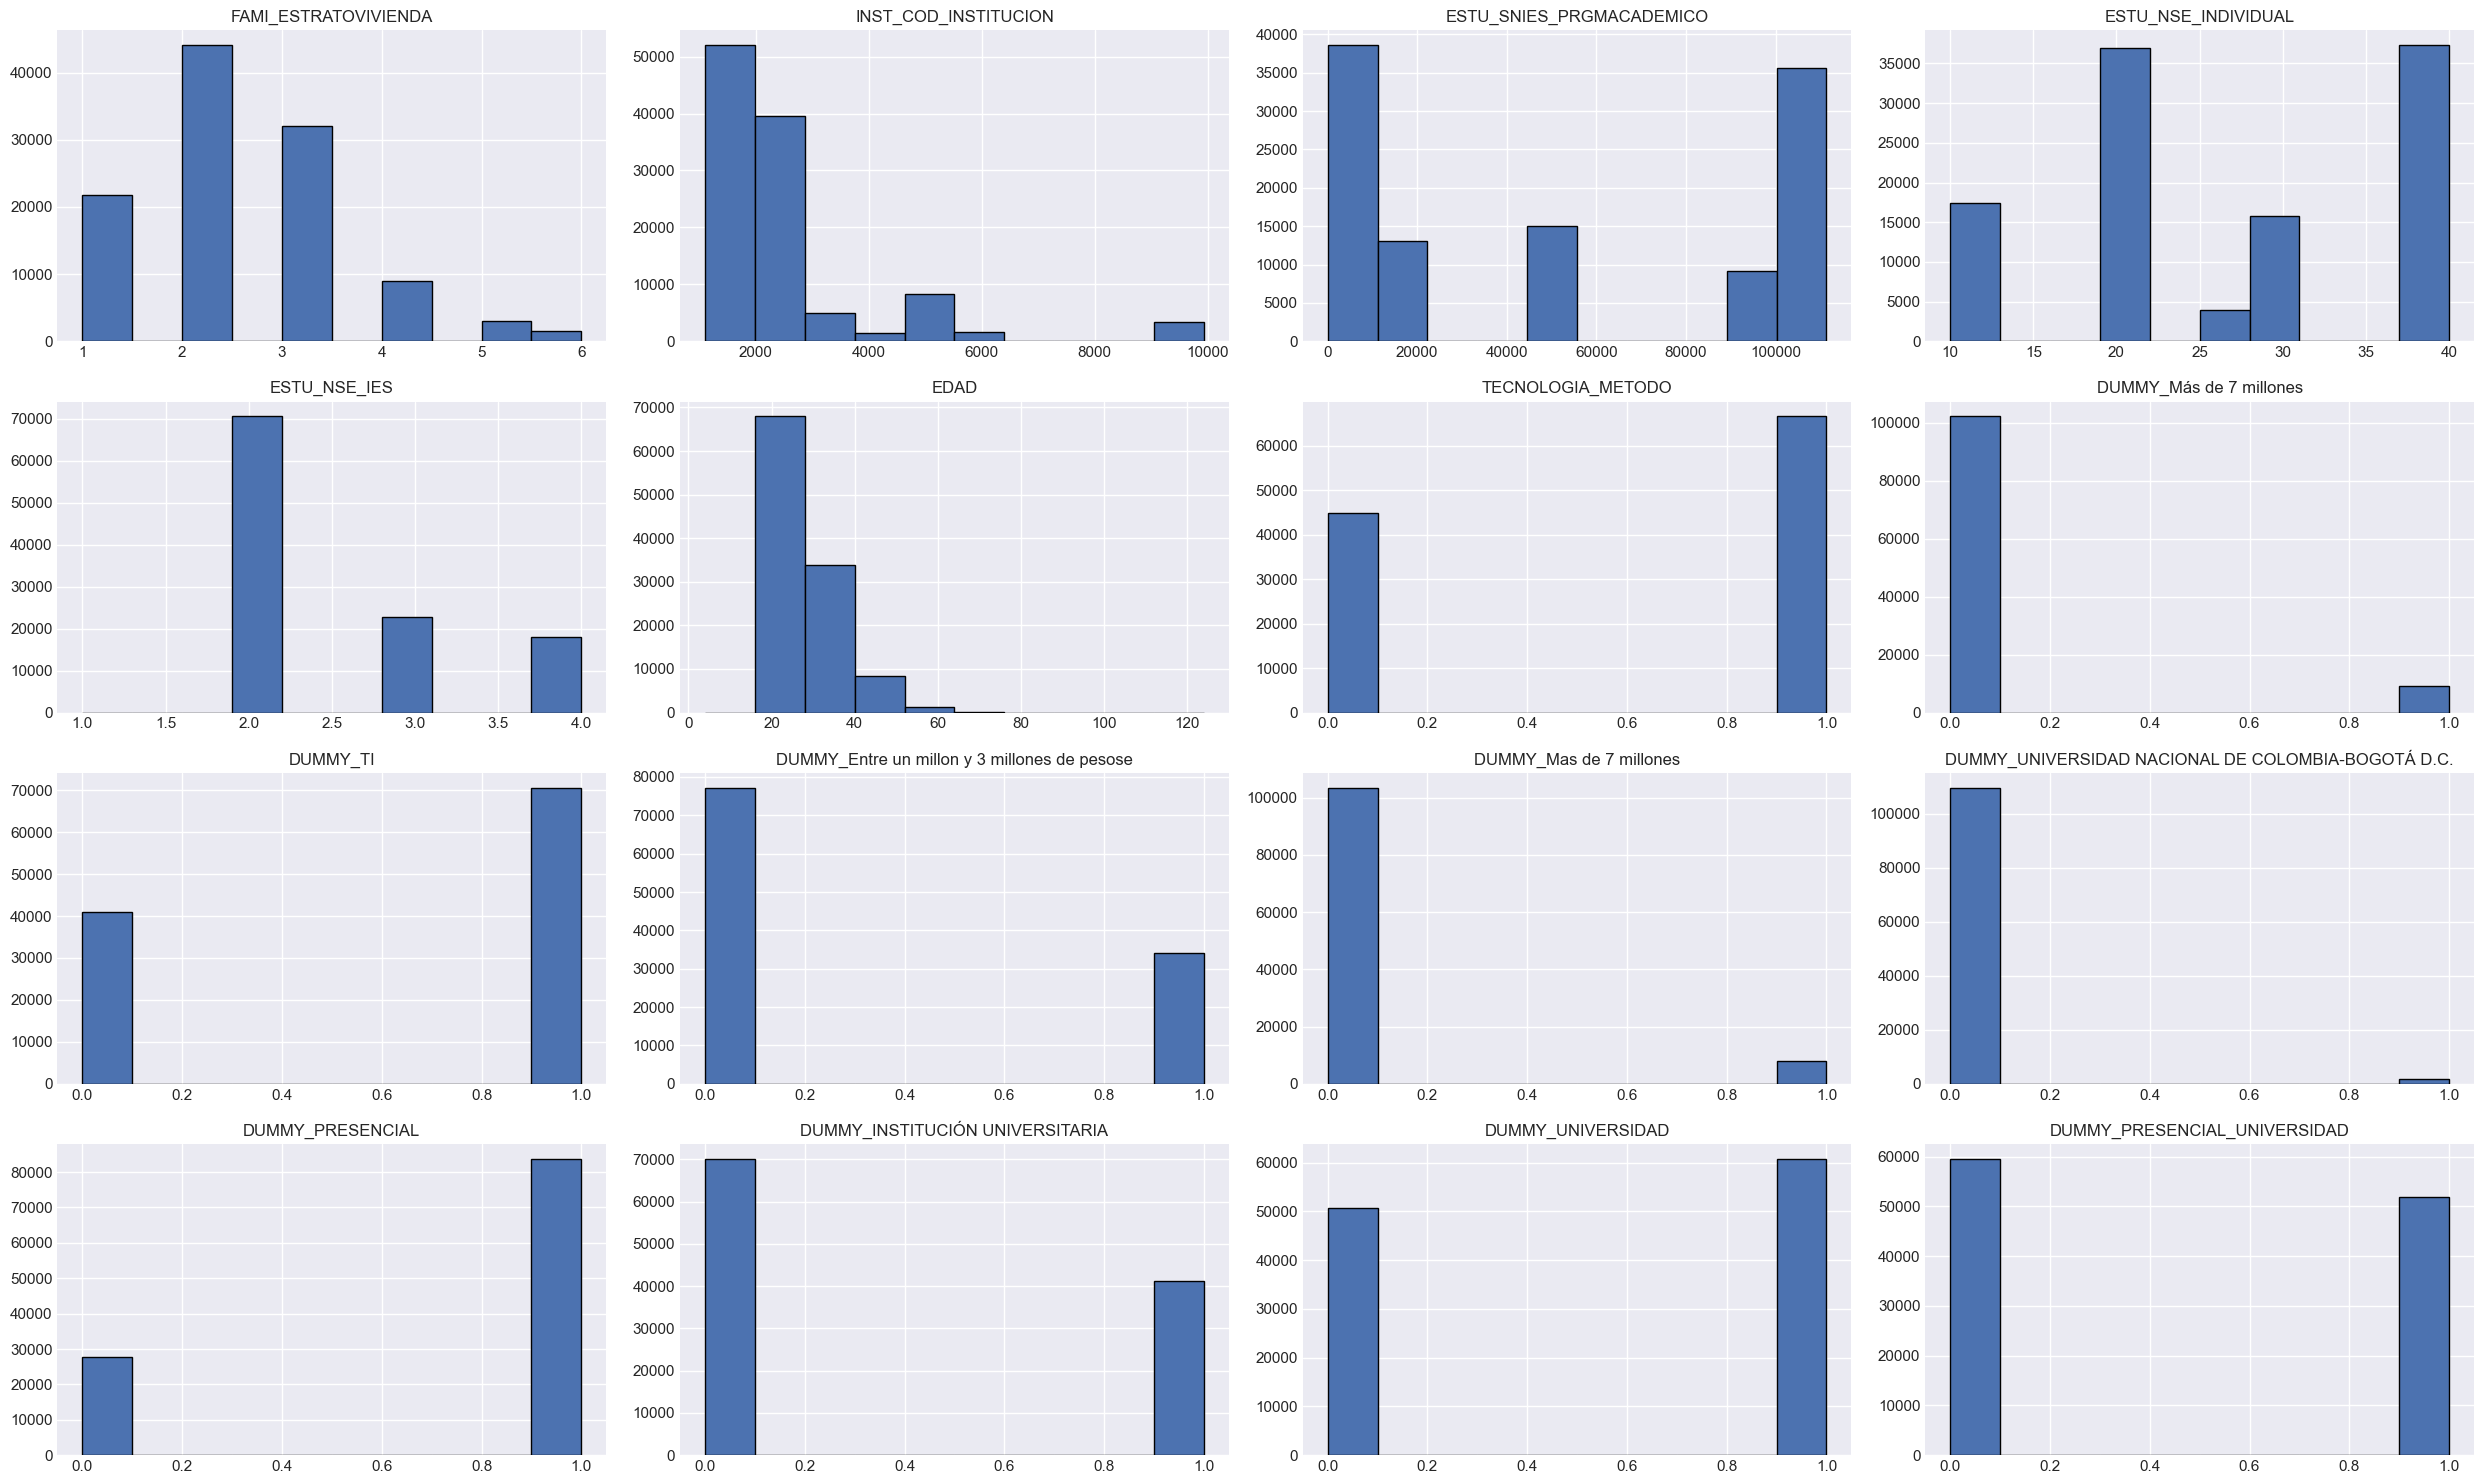

In [169]:
# Crear un histograma para cada columna numérica
df[filtered_corr_df['Variable']].hist(figsize=(25, 15), bins=10, edgecolor='black')

plt.tight_layout()
plt.show()

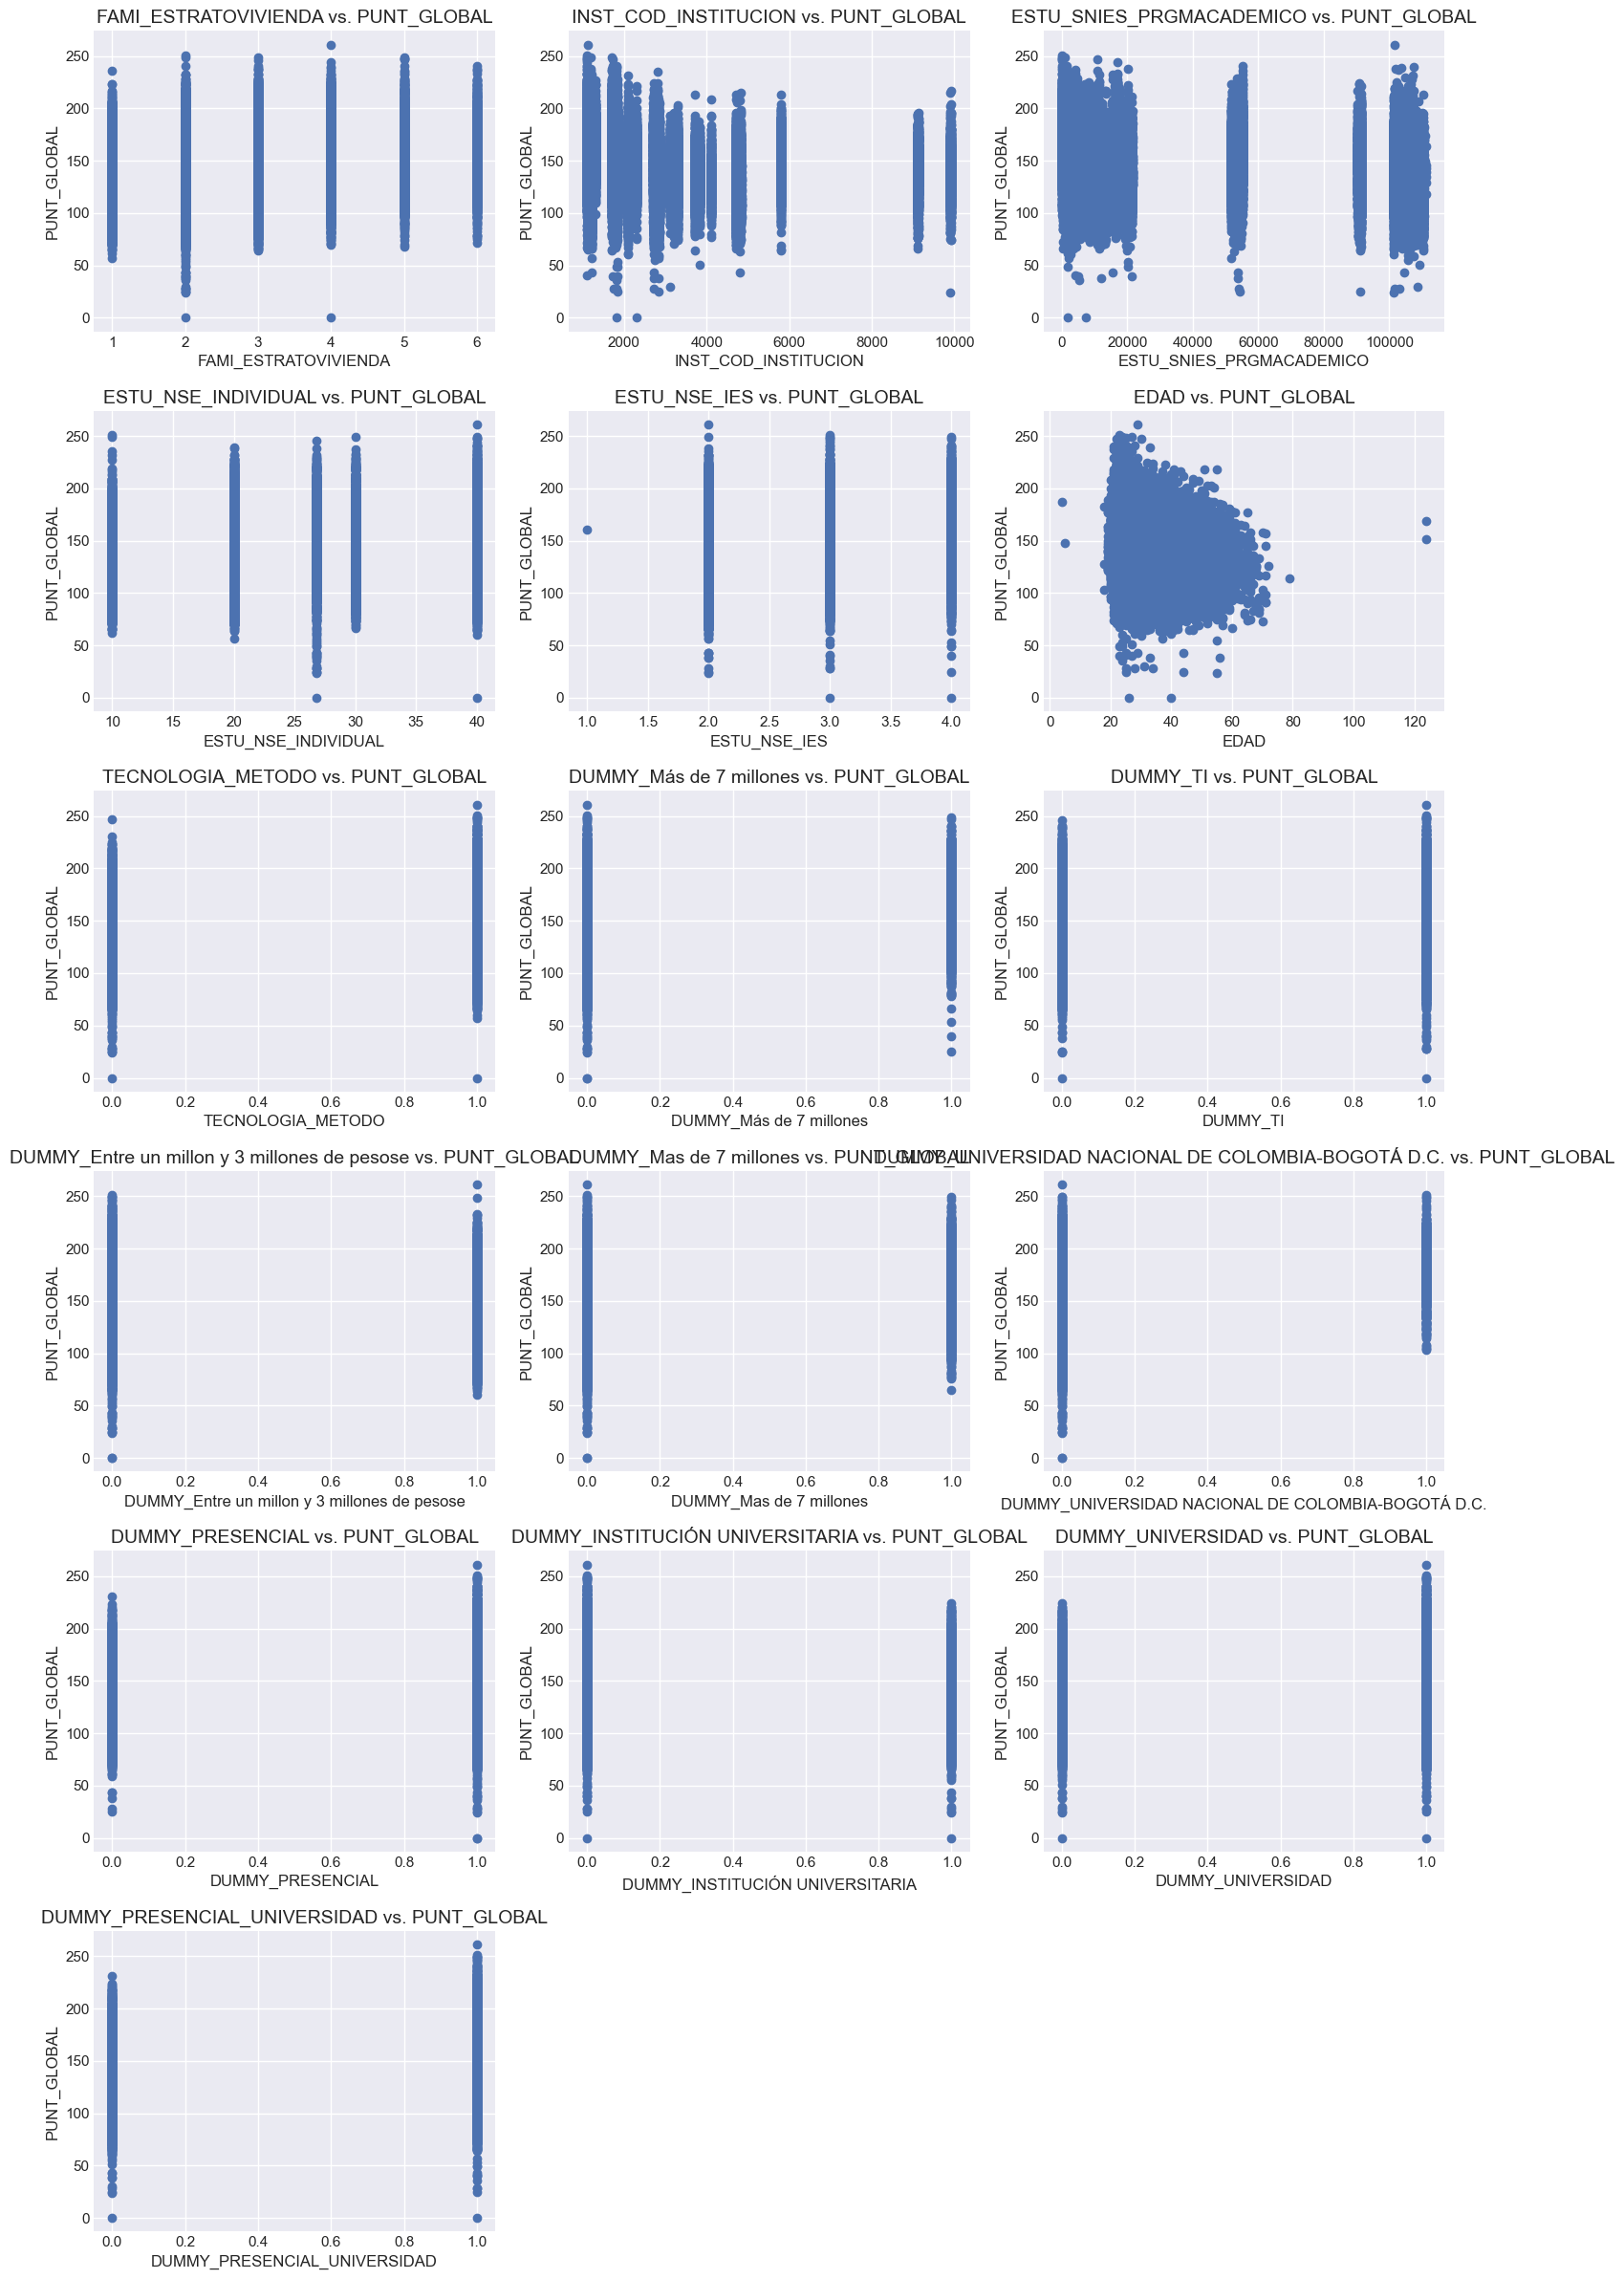

In [178]:
# Filtramos las variables numéricas
numerical_columns = filtered_corr_df['Variable'].tolist()


# Configuramos el número de columnas y filas de subgráficas
cols = 3  # Número de columnas de subgráficas
rows = (len(numerical_columns) // cols) + (len(numerical_columns) % cols > 0)  # Calculamos filas necesarias

plt.figure(figsize=(15, 4 * rows))

# Creamos las subgráficas
for i, var in enumerate(numerical_columns):
    plt.subplot(rows, cols, i + 1)  # Seleccionamos la subgráfica
    plt.scatter(df[var], df['PUNT_GLOBAL'])
    plt.title(f'{var} vs. PUNT_GLOBAL', fontsize=14)
    plt.xlabel(var, fontsize=12)
    plt.ylabel('PUNT_GLOBAL', fontsize=12)
    plt.grid(True)

plt.tight_layout()  # Ajusta la disposición
plt.show()  # Muestra la figura

In [ ]:
# Hacer la limpieza para los datos de testing que se van a enviar a kaggle

dl = pd.read_csv('../data/test_pruebas.csv', encoding='latin1', sep=';', on_bad_lines='skip')

In [103]:
# Aqui se va tener el id del estudiente para la prediccion
id = dl['ESTU_CONSECUTIVO']

In [104]:
numeric_cols = dl.select_dtypes(include=np.number).columns
for col in numeric_cols:
    mean_value = dl[col].mean()
    dl[col].fillna(mean_value, inplace=True)  



In [105]:
dl['FAMI_ESTRATOVIVIENDA'] = dl['FAMI_ESTRATOVIVIENDA'].str.replace('Estrato ', '').str.strip()
dl['FAMI_ESTRATOVIVIENDA'] = pd.to_numeric(dl['FAMI_ESTRATOVIVIENDA'], errors='coerce')

mean_value = round(dl['FAMI_ESTRATOVIVIENDA'].mean())


dl['FAMI_ESTRATOVIVIENDA'].fillna(mean_value, inplace=True)

dl['FAMI_ESTRATOVIVIENDA'] = dl['FAMI_ESTRATOVIVIENDA'].astype(int)

In [106]:


dl['FAMI_EDUCACION_PADRES_COMBINADA'] = dl['FAMI_EDUCACIONPADRE'] + dl['FAMI_EDUCACIONMADRE']

dl['ACCESO_TECNOLOGIA'] = ((dl['FAMI_TIENECOMPUTADOR'] == 'Si') & (dl['FAMI_TIENEINTERNET'] == 'Si')).astype(int)

def categorizar_horas_trabajo(horas):
    if horas == '0':
        return 'No trabaja'
    elif horas == 'Menos de 10 horas':
        return 'Tiempo parcial bajo'
    elif horas in ['Entre 11 y 20 horas', 'Entre 21 y 30 horas']:
        return 'Tiempo parcial alto'
    else:
        return 'Tiempo completo'

dl['NIVEL_TRABAJO_ESTUDIANTE'] = dl['ESTU_HORASSEMANATRABAJA'].apply(categorizar_horas_trabajo)

dl['PREPARO_EXAMEN'] = (dl['ESTU_COMOCAPACITOEXAMENSB11'] != 'No realizó ninguna prueba de preparación').astype(int)

def combinar_estrato_matricula(estrato, matricula):
    if pd.isna(estrato) or pd.isna(matricula):
        return np.nan
    return f"{estrato}_{matricula}"

dl['ESTRATO_MATRICULA'] = dl.apply(lambda row: combinar_estrato_matricula(row['FAMI_ESTRATOVIVIENDA'], row['ESTU_VALORMATRICULAUNIVERSIDAD']), axis=1)


dl['PRIMERA_GENERACION_UNIV'] = ((dl['FAMI_EDUCACIONPADRE'] != 'Educación profesional completa') & 
                                 (dl['FAMI_EDUCACIONMADRE'] != 'Educación profesional completa')).astype(int)


dl['METODO_CARACTER_COMBINADO'] = dl['ESTU_METODO_PRGM'] + '_' + dl['INST_CARACTER_ACADEMICO']


dl['RESIDE_DONDE_ESTUDIA'] = (dl['ESTU_MCPIO_RESIDE'] == dl['ESTU_PRGM_MUNICIPIO']).astype(int)



In [ ]:
from datetime import datetime

dl['ESTU_FECHANACIMIENTO'] = pd.to_datetime(dl['ESTU_FECHANACIMIENTO'], format='%d/%m/%Y', errors='coerce')
fecha_actual = pd.to_datetime(datetime.today())


dl['EDAD'] = (fecha_actual - dl['ESTU_FECHANACIMIENTO']).dt.days // 365
dl.drop(columns='ESTU_FECHANACIMIENTO', inplace=True)


mean_value = dl['EDAD'].mean()
dl['EDAD'].fillna(mean_value, inplace=True) 

dl['EDAD'].head(5)



In [110]:
dl['TECNOLOGIA_METODO'] = dl['ACCESO_TECNOLOGIA'] * pd.get_dummies(dl['ESTU_METODO_PRGM'])['PRESENCIAL']

dl['TRABAJO_PREPARACION'] = dl['NIVEL_TRABAJO_ESTUDIANTE'].astype(str) + '_' + dl['PREPARO_EXAMEN'].astype(str)
dl = pd.get_dummies(dl, columns=['TRABAJO_PREPARACION'], drop_first=True)


In [ ]:
categorical_cols = dl.select_dtypes(include=np.object_).columns

for column in categorical_cols: unique_count = dl[column].nunique()
    
dl.shape

In [ ]:
columns_to_remove = []

for column in categorical_cols:
    if dl[column].nunique() <= 1 or dl[column].nunique() >= 1000:  columns_to_remove.append(column)

if columns_to_remove:
    dl.drop(columns=columns_to_remove, inplace=True)

    for column in columns_to_remove:
        print(f"Eliminada columna: {column}")
dl.shape


In [ ]:
categorical_col = dl.select_dtypes(include='object').columns


for column in categorical_col:

    dummies = pd.get_dummies(dl[column], prefix='DUMMY', drop_first=True)
    
    dl = pd.concat([dl, dummies], axis=1)

dl.drop(columns=categorical_col, inplace=True)

print("DataFrame final con las columnas dummy añadidas:")


In [ ]:
dp = dl[filtered_corr_df['Variable']]

# Eliminar columnas duplicadas en 'dp'. Por si alguna de las columnas estan repetidas en el dl
dp = dp.loc[:, ~dp.columns.duplicated()]


len(dp.columns)



In [ ]:
#REGRESION LINEAL
y_test_pred = pipeline.predict(dp)

predicciones_dm = pd.DataFrame({
    'ID': id,  # ESTE ES EL ID CONSECUTIO DEL ESTUDIANTE, SE SACA ANTES DE SER ELIMINADO 
    'TARGET': y_test_pred
})

output_file = '../resultados/Regression.csv'
predicciones_dm.to_csv(output_file, index=False)

print(f"Predicciones guardadas en el archivo: {output_file}")

In [ ]:
# KNN
y_test_pred = knn.predict(dp)

predicciones_dm = pd.DataFrame({
    'id': id, 
    'TARGET': y_test_pred
})

output_file = '../resultados/Knn_20.csv'
predicciones_dm.to_csv(output_file, index=False)

print(f"Predicciones guardadas en el archivo: {output_file}")

In [ ]:
# GBM
y_pred = gbm.predict(dp)

predicciones_dm = pd.DataFrame({
    'id': id, 
    'TARGET': y_pred
})

output_file = '../resultados/gbm.csv'
predicciones_dm.to_csv(output_file, index=False)

print(f"Predicciones guardadas en el archivo: {output_file}")